In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from spafe.features.pncc import pncc

In [161]:
df = pd.read_csv('./coconut-maturity-dataset-wav-luar-kotak.csv')
df

,full_path,file_name,class_name
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature
...,...,...,...
175,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature
176,./Sample-kelapa/data/cut_sample/tua/wav/tua8c.wav,tua8c.wav,overmature
177,./Sample-kelapa/data/cut_sample/tua/wav/tua9a.wav,tua9a.wav,overmature
178,./Sample-kelapa/data/cut_sample/tua/wav/tua9b.wav,tua9b.wav,overmature


In [162]:
def createWaveplot(data, sampleRate, maturity, color):
    plt.figure(figsize=(8,2))
    plt.title(f'Waveplot for {maturity} maturity', size = 15, pad = 20)
    librosa.display.waveshow(data, sr=sampleRate, alpha=0.5, color=color)
    plt.show()

def amplitude_envelope(signal, frame_size: int = 2048, hop_length: int = 512):
    """Calculate the amplitude envelope of a signal with a given frame size nad hop length."""
    amplitude_envelope = []
    
    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), hop_length): 
        amplitude_envelope_current_frame = max(signal[i:i+frame_size]) 
        amplitude_envelope.append(amplitude_envelope_current_frame)
    
    return np.array(amplitude_envelope)

In [165]:
pnccs = []
mfccs = []
pncc_vectors = []
mfcc_vectors = []
zcr = []
ae = []
rmse = []

for filename in df['full_path'].values:
    wavSig, sampRate = librosa.load(filename)
    pncc_result = pncc(wavSig, fs=sampRate)
    mfcc_result = librosa.feature.mfcc(y=wavSig, sr=sampRate)
    pnccs.append(pncc_result)
    mfccs.append(mfcc_result)
    pncc_vectors.append(pncc_result.shape)
    mfcc_vectors.append(mfcc_result.shape)
    ae_result = amplitude_envelope(wavSig)
    zcr_result = librosa.feature.zero_crossing_rate(wavSig)
    rmse_result = librosa.feature.rms(y=wavSig)
    ae.append(ae_result)
    zcr.append(zcr_result[0])
    rmse.append(rmse_result[0])

d:\Cool Yeah\Semester 118\coconut-maturity-classification\envSkripsi\lib\site-packages\spafe\features\pncc.py:169: RuntimeWarning: invalid value encountered in scalar divide
  [R_tilde[m, lprime] / Q_tilde[m, lprime] for lprime in range(l1, l2)]
d:\Cool Yeah\Semester 118\coconut-maturity-classification\envSkripsi\lib\site-packages\spafe\features\pncc.py:169: RuntimeWarning: divide by zero encountered in scalar divide
  [R_tilde[m, lprime] / Q_tilde[m, lprime] for lprime in range(l1, l2)]
d:\Cool Yeah\Semester 118\coconut-maturity-classification\envSkripsi\lib\site-packages\spafe\features\pncc.py:437: RuntimeWarning: invalid value encountered in multiply
  T = P * S_tilde


In [166]:
df['PNCC-feature'] = pnccs
df['PNCC-feature-size'] = pncc_vectors
df['MFCC-feature'] = mfccs
df['MFCC-feature-size'] = mfcc_vectors
df['amplitude-envelope'] = ae
df['zero-crossing-rate'] = zcr
df['RMS-energy'] = rmse
df

,full_path,file_name,class_name,PNCC-feature,PNCC-feature-size,MFCC-feature,MFCC-feature-size,amplitude-envelope,zero-crossing-rate,RMS-energy
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature,"[[2.000098246886966, -0.32312278051968846, 0.0...","(98, 13)","[[-726.5902, -726.04486, -725.31476, -724.9084...","(20, 44)","[5.2741158e-05, 6.533848e-05, 6.533848e-05, 7....","[0.169921875, 0.2451171875, 0.322265625, 0.323...","[1.741442e-05, 2.2019052e-05, 2.6264723e-05, 2..."
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature,"[[2.03020507353705, -0.3081231693218536, 0.023...","(98, 13)","[[-660.823, -660.6598, -660.7989, -660.306, -6...","(20, 44)","[8.562851e-05, 0.000106699576, 0.000106699576,...","[0.1552734375, 0.2197265625, 0.2861328125, 0.2...","[1.9825766e-05, 2.5567619e-05, 3.1338837e-05, ..."
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature,"[[2.053201586789632, -0.30926271900245395, 0.0...","(98, 13)","[[-673.22833, -673.176, -673.22833, -672.8981,...","(20, 44)","[7.664046e-05, 7.664046e-05, 9.752976e-05, 9.7...","[0.1484375, 0.20947265625, 0.2802734375, 0.273...","[1.908695e-05, 2.4348914e-05, 2.868397e-05, 2...."
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature,"[[2.1524977561943794, -0.2745882742675701, -0....","(98, 13)","[[-703.6863, -698.70905, -670.14465, -658.5095...","(20, 44)","[0.0004190257, 0.0004190257, 0.0004190257, 0.0...","[0.11865234375, 0.1572265625, 0.17919921875, 0...","[2.8227014e-05, 7.7885874e-05, 0.00011563334, ..."
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature,"[[2.085433271523342, -0.3482630528427392, -0.0...","(98, 13)","[[-690.01776, -689.66144, -689.2191, -689.339,...","(20, 44)","[6.3666506e-05, 6.1336046e-05, 5.338081e-05, 5...","[0.15625, 0.23095703125, 0.30322265625, 0.3066...","[2.0658814e-05, 2.5298703e-05, 2.9047435e-05, ..."
...,...,...,...,...,...,...,...,...,...,...
175,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature,"[[2.0537136283217605, -0.3141183737907519, 0.0...","(98, 13)","[[-714.5778, -713.85254, -713.69366, -705.8138...","(20, 44)","[0.00012795377, 0.0001551585, 0.00016831578, 0...","[0.16064453125, 0.23095703125, 0.27490234375, ...","[1.839841e-05, 2.621859e-05, 3.6141188e-05, 4...."
176,./Sample-kelapa/data/cut_sample/tua/wav/tua8c.wav,tua8c.wav,overmature,"[[1.9822215851057952, -0.3148358106033424, 0.0...","(98, 13)","[[-712.34656, -712.0022, -712.6092, -712.62354...","(20, 44)","[3.748658e-05, 3.748658e-05, 3.748658e-05, 3.9...","[0.1845703125, 0.26416015625, 0.3564453125, 0....","[1.7385477e-05, 2.1367476e-05, 2.4571253e-05, ..."
177,./Sample-kelapa/data/cut_sample/tua/wav/tua9a.wav,tua9a.wav,overmature,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","(98, 13)","[[-689.2629, -689.2629, -689.2629, -689.2629, ...","(20, 44)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
178,./Sample-kelapa/data/cut_sample/tua/wav/tua9b.wav,tua9b.wav,overmature,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","(98, 13)","[[-677.02826, -677.02826, -677.02826, -677.028...","(20, 44)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [167]:
df.to_csv('extracted-features.csv', index=False)

In [198]:
df_cut = df[df['PNCC-feature'].apply(lambda x: not np.isnan(x).any())]
df_cut.reset_index(drop=True, inplace=True)
df_cut

,full_path,file_name,class_name,PNCC-feature,PNCC-feature-size,MFCC-feature,MFCC-feature-size,amplitude-envelope,zero-crossing-rate,RMS-energy
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature,"[[2.000098246886966, -0.32312278051968846, 0.0...","(98, 13)","[[-726.5902, -726.04486, -725.31476, -724.9084...","(20, 44)","[5.2741158e-05, 6.533848e-05, 6.533848e-05, 7....","[0.169921875, 0.2451171875, 0.322265625, 0.323...","[1.741442e-05, 2.2019052e-05, 2.6264723e-05, 2..."
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature,"[[2.03020507353705, -0.3081231693218536, 0.023...","(98, 13)","[[-660.823, -660.6598, -660.7989, -660.306, -6...","(20, 44)","[8.562851e-05, 0.000106699576, 0.000106699576,...","[0.1552734375, 0.2197265625, 0.2861328125, 0.2...","[1.9825766e-05, 2.5567619e-05, 3.1338837e-05, ..."
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature,"[[2.053201586789632, -0.30926271900245395, 0.0...","(98, 13)","[[-673.22833, -673.176, -673.22833, -672.8981,...","(20, 44)","[7.664046e-05, 7.664046e-05, 9.752976e-05, 9.7...","[0.1484375, 0.20947265625, 0.2802734375, 0.273...","[1.908695e-05, 2.4348914e-05, 2.868397e-05, 2...."
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature,"[[2.1524977561943794, -0.2745882742675701, -0....","(98, 13)","[[-703.6863, -698.70905, -670.14465, -658.5095...","(20, 44)","[0.0004190257, 0.0004190257, 0.0004190257, 0.0...","[0.11865234375, 0.1572265625, 0.17919921875, 0...","[2.8227014e-05, 7.7885874e-05, 0.00011563334, ..."
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature,"[[2.085433271523342, -0.3482630528427392, -0.0...","(98, 13)","[[-690.01776, -689.66144, -689.2191, -689.339,...","(20, 44)","[6.3666506e-05, 6.1336046e-05, 5.338081e-05, 5...","[0.15625, 0.23095703125, 0.30322265625, 0.3066...","[2.0658814e-05, 2.5298703e-05, 2.9047435e-05, ..."
...,...,...,...,...,...,...,...,...,...,...
134,./Sample-kelapa/data/cut_sample/tua/wav/tua2c.wav,tua2c.wav,overmature,"[[2.021531665614917, -0.32578074400792156, 0.0...","(98, 13)","[[-706.5763, -706.55695, -706.5829, -706.5764,...","(20, 44)","[4.4958317e-05, 4.4958317e-05, 5.7125806e-05, ...","[0.16796875, 0.2421875, 0.33203125, 0.33007812...","[1.7348988e-05, 2.1297352e-05, 2.4144223e-05, ..."
135,./Sample-kelapa/data/cut_sample/tua/wav/tua4a.wav,tua4a.wav,overmature,"[[2.1749682479502663, -0.3603752471296788, -0....","(98, 13)","[[-761.9785, -753.03973, -747.70654, -745.4355...","(20, 44)","[0.00015697465, 0.0001644985, 0.0001644985, 0....","[0.11376953125, 0.1689453125, 0.21630859375, 0...","[3.4832294e-05, 4.397031e-05, 5.5298387e-05, 5..."
136,./Sample-kelapa/data/cut_sample/tua/wav/tua8a.wav,tua8a.wav,overmature,"[[2.1839039600808268, -0.4485276294821634, 0.0...","(98, 13)","[[-723.2729, -720.58295, -724.2534, -725.74774...","(20, 44)","[0.00016171605, 0.00015997203, 8.671761e-05, 8...","[0.166015625, 0.24951171875, 0.33154296875, 0....","[3.8330938e-05, 4.2394706e-05, 4.485954e-05, 3..."
137,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature,"[[2.0537136283217605, -0.3141183737907519, 0.0...","(98, 13)","[[-714.5778, -713.85254, -713.69366, -705.8138...","(20, 44)","[0.00012795377, 0.0001551585, 0.00016831578, 0...","[0.16064453125, 0.23095703125, 0.27490234375, ...","[1.839841e-05, 2.621859e-05, 3.6141188e-05, 4...."


In [206]:
import numpy as np

# Assuming you have the individual feature arrays for each data point
feature1 = np.random.random((60, 98, 13))
feature2 = np.random.random((60, 20, 44))
feature3 = np.random.random((60, 44))
feature4 = np.random.random((60, 44))
feature5 = np.random.random((60, 44))

# Concatenate the features along the appropriate axis
X = np.concatenate((feature1.reshape(60, -1),
                    feature2.reshape(60, -1),
                    feature3.reshape(60, -1),
                    feature4.reshape(60, -1),
                    feature5.reshape(60, -1)), axis=1)

# Create the labels array
labels = np.repeat(['LabelA', 'LabelB', 'LabelC'], 60)

In [220]:
print(np.stack(df_cut['PNCC-feature'].values).shape)
print(np.stack(df_cut['MFCC-feature'].values).shape)
print(np.stack(df_cut['amplitude-envelope'].values).shape)
print(np.stack(df_cut['zero-crossing-rate'].values).shape)
print(np.stack(df_cut['RMS-energy'].values).shape)

(139, 98, 13)
(139, 20, 44)
(139, 44)
(139, 44)
(139, 44)


In [233]:
pncc_feature = np.stack(df_cut['PNCC-feature'].values)
mfcc_feature = np.stack(df_cut['MFCC-feature'].values)
ae_feature = np.stack(df_cut['amplitude-envelope'].values)
zcr_feature = np.stack(df_cut['zero-crossing-rate'].values)
rmse_feature = np.stack(df_cut['RMS-energy'].values)

X = np.concatenate((pncc_feature.reshape(139, -1),
                    mfcc_feature.reshape(139, -1),
                    ae_feature.reshape(139, -1),
                    zcr_feature.reshape(139, -1),
                    rmse_feature.reshape(139, -1)), axis=1)

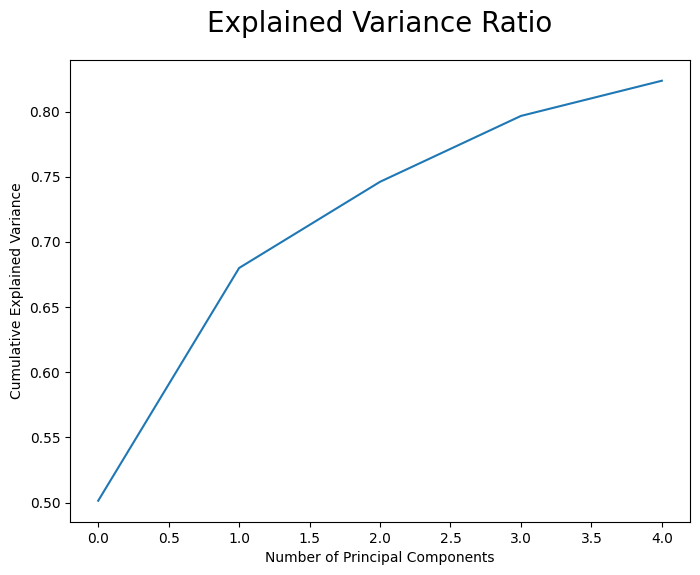

In [230]:
pca = PCA(n_components=5)
pca.fit(X)
pca_result = pca.transform(X)

plt.subplots(figsize = (8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio', fontsize=20, pad=20)
plt.show()

C:\Users\hi\AppData\Local\Temp\ipykernel_10840\3587329436.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x[indices], y[indices], c=label_colors[label], cmap='viridis')


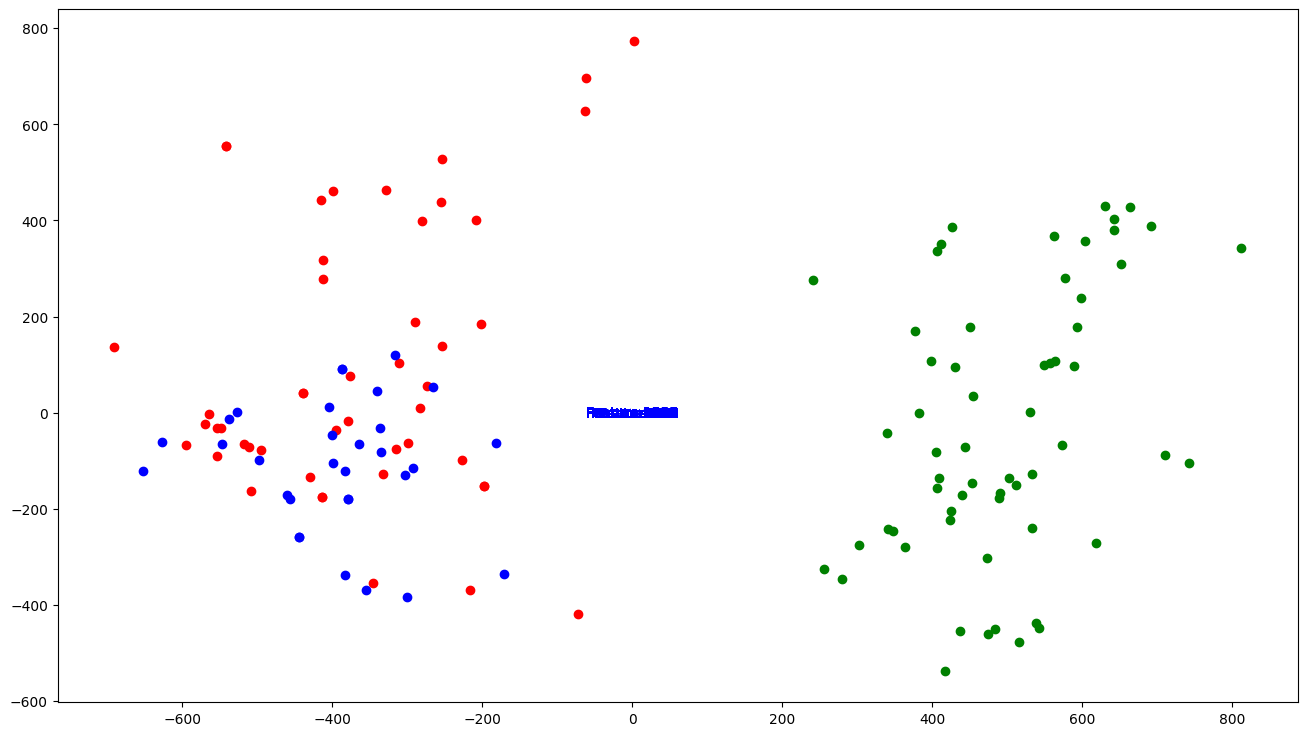

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = df_cut['class_name'].values.tolist()

# Create a dictionary to map labels to colors for plotting
label_colors = {'mature': 'red', 'immature': 'green', 'overmature': 'blue'}

x = pca_result[:, 0]
y = pca_result[:, 1]

unique_labels = set(labels)

fig, ax = plt.subplots(figsize=(16, 9))
for label in unique_labels:
    indices = np.where(np.array(labels) == label)
    ax.scatter(x[indices], y[indices], c=label_colors[label], cmap='viridis')

# plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')
feature_vectors = pca.components_.T
arrow_scale = 0.2
for i, feature in enumerate(feature_vectors):
    plt.arrow(0, 0, arrow_scale * feature[0], arrow_scale * feature[1], color='r', alpha=0.5)
    plt.text(feature[0] * 1.15, feature[1] * 1.15, f'Feature {i+1}', color='b', ha='center', va='center')

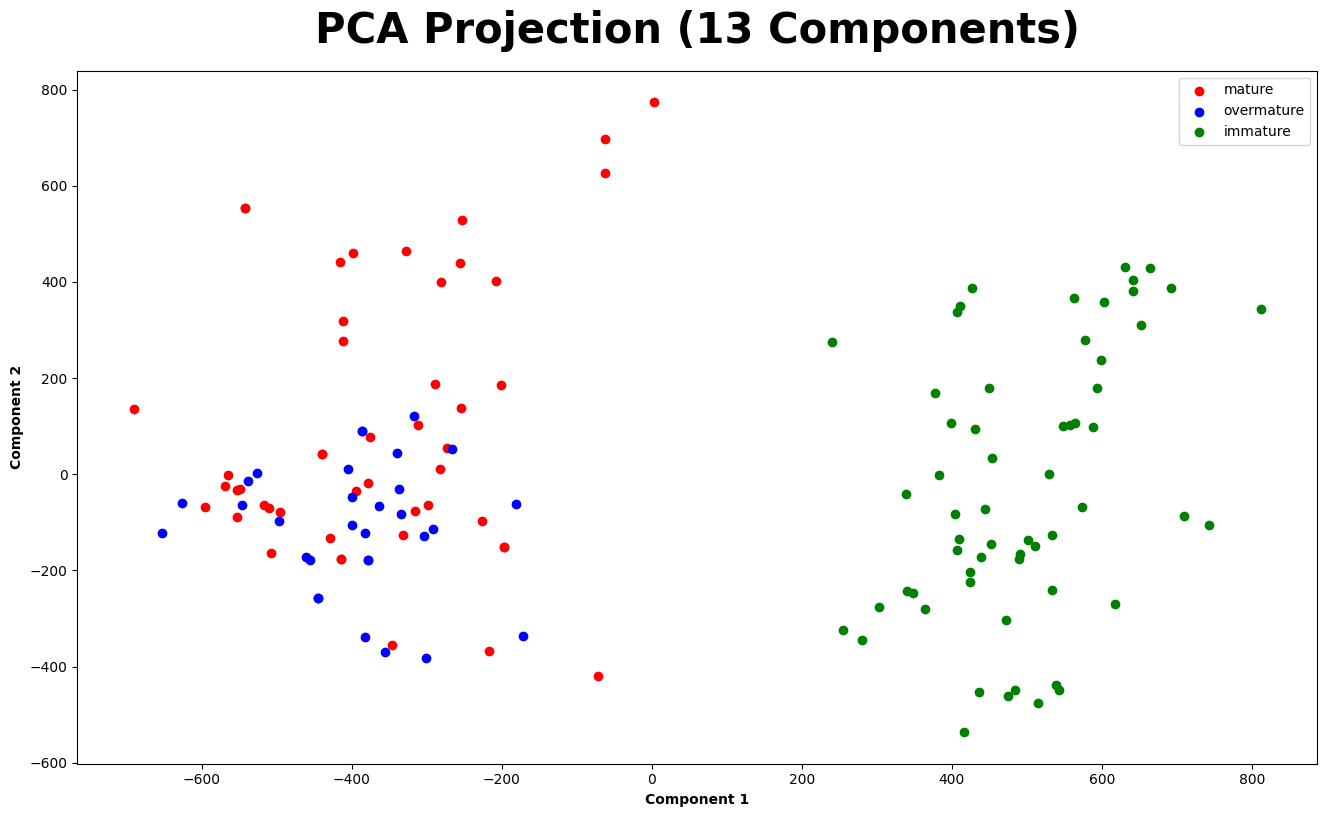

In [232]:
labels = df_cut['class_name'].values.tolist()

# Create a dictionary to map labels to colors for plotting
label_colors = {'mature': 'red', 'immature': 'green', 'overmature': 'blue'}

x = pca_result[:, 0]
y = pca_result[:, 1]

unique_labels = set(labels)

fig, ax = plt.subplots(figsize=(16, 9))
for label in unique_labels:
    indices = np.where(np.array(labels) == label)
    ax.scatter(x[indices], y[indices], c=label_colors[label], label=label)

plt.title('PCA Projection (13 Components)', fontsize=30, pad=20, fontweight='bold')
plt.xlabel('Component 1', fontweight='bold')
plt.ylabel('Component 2', fontweight='bold')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [176]:
df['amplitude-envelope'].values[0].shape

(44,)

In [201]:
np.stack(df_cut['PNCC-feature'].values).shape

(139, 98, 13)

In [203]:
np.stack(df_cut['PNCC-feature'].values).reshape((139, -1)).shape

(139, 1274)

In [186]:
df['PNCC-feature'].values[0].flatten()

array([ 2.00009825, -0.32312278,  0.01555734, ..., -0.02381299,
       -0.00239147, -0.0128392 ])

In [189]:
df['PNCC-feature'].values[0].ravel()

array([ 2.00009825, -0.32312278,  0.01555734, ..., -0.02381299,
       -0.00239147, -0.0128392 ])

In [187]:
df['PNCC-feature'].values[0].flatten().shape

(1274,)

In [ ]:
zero_crossing_rate = librosa.feature.zero_crossing_rate(immature)
rms_energy = librosa.feature.rms(y=immature)

In [213]:
print(feature1.shape)
print(feature2.shape)
print(feature3.shape)
print(feature4.shape)
print(feature5.shape)

(60, 98, 13)
(60, 20, 44)
(60, 44)
(60, 44)
(60, 44)


In [211]:
X.shape

(60, 2286)

In [208]:
labels.shape

(180,)

In [112]:
from spafe.features.pncc import pncc
pnccs = []
vector_size = []

for filename in df['full_path'].values:
    wavSig, sampRate = librosa.load(filename)
    result = pncc(wavSig, fs=sampRate)
    pnccs.append(result)
    vector_size.append(result.shape)

d:\Cool Yeah\Semester 118\coconut-maturity-classification\envSkripsi\lib\site-packages\spafe\features\pncc.py:169: RuntimeWarning: invalid value encountered in scalar divide
  [R_tilde[m, lprime] / Q_tilde[m, lprime] for lprime in range(l1, l2)]
d:\Cool Yeah\Semester 118\coconut-maturity-classification\envSkripsi\lib\site-packages\spafe\features\pncc.py:169: RuntimeWarning: divide by zero encountered in scalar divide
  [R_tilde[m, lprime] / Q_tilde[m, lprime] for lprime in range(l1, l2)]
d:\Cool Yeah\Semester 118\coconut-maturity-classification\envSkripsi\lib\site-packages\spafe\features\pncc.py:437: RuntimeWarning: invalid value encountered in multiply
  T = P * S_tilde


In [113]:
df['PNCC-feature'] = pnccs
df['PNCC-feature-size'] = vector_size

df

,full_path,file_name,class_name,PNCC-feature,PNCC-feature-size
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature,"[[2.000098246886966, -0.32312278051968846, 0.0...","(98, 13)"
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature,"[[2.03020507353705, -0.3081231693218536, 0.023...","(98, 13)"
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature,"[[2.053201586789632, -0.30926271900245395, 0.0...","(98, 13)"
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature,"[[2.1524977561943794, -0.2745882742675701, -0....","(98, 13)"
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature,"[[2.085433271523342, -0.3482630528427392, -0.0...","(98, 13)"
...,...,...,...,...,...
175,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature,"[[2.0537136283217605, -0.3141183737907519, 0.0...","(98, 13)"
176,./Sample-kelapa/data/cut_sample/tua/wav/tua8c.wav,tua8c.wav,overmature,"[[1.9822215851057952, -0.3148358106033424, 0.0...","(98, 13)"
177,./Sample-kelapa/data/cut_sample/tua/wav/tua9a.wav,tua9a.wav,overmature,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","(98, 13)"
178,./Sample-kelapa/data/cut_sample/tua/wav/tua9b.wav,tua9b.wav,overmature,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","(98, 13)"


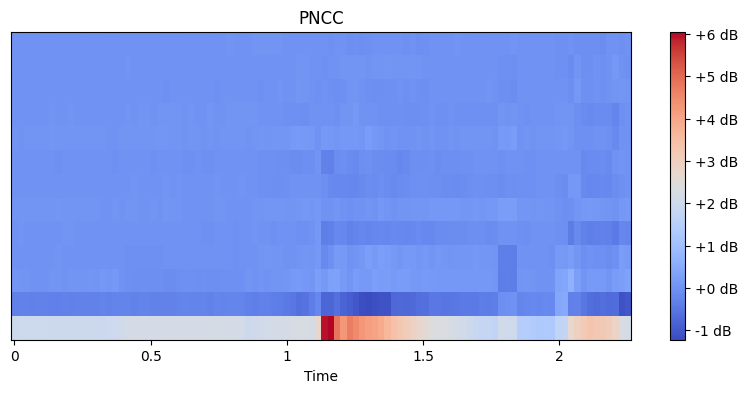

In [75]:
from spafe.features.pncc import pncc
wavSig, sampRate = librosa.load(df['full_path'].values[-4])
pncc_result = pncc(wavSig, fs=sampRate)

plt.figure(figsize=(10, 4))
librosa.display.specshow(np.transpose(pncc_result), x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('PNCC')
plt.show()

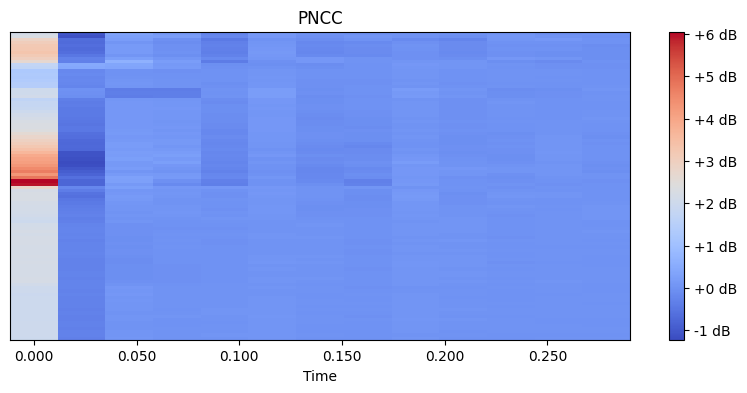

In [76]:
from spafe.features.pncc import pncc
wavSig, sampRate = librosa.load(df['full_path'].values[-4])
pncc_result = pncc(wavSig, fs=sampRate)

plt.figure(figsize=(10, 4))
librosa.display.specshow(pncc_result, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('PNCC')
plt.show()

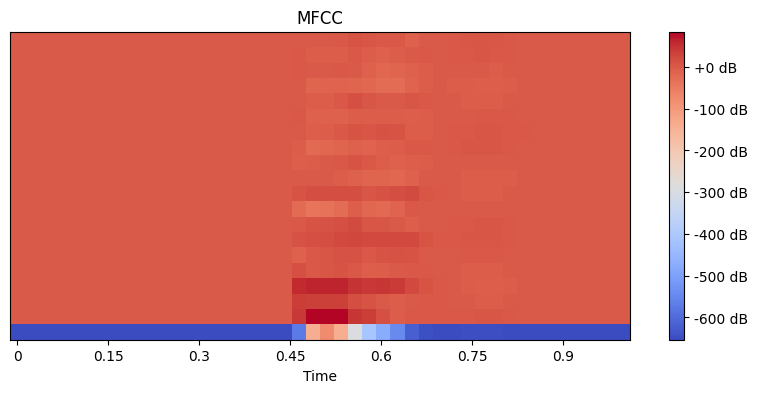

In [64]:
wavSig, sampRate = librosa.load(filename)
mfcc_result = librosa.feature.mfcc(y=wavSig, sr=sampRate)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_result, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.show()

In [71]:
print(pncc_result.shape)
print(np.transpose(pncc_result).shape)
print(mfcc_result.shape)

(98, 13)
(13, 98)
(20, 44)


In [72]:
print(pncc_result)
print(mfcc_result)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[-6.53338867e+02 -6.53338867e+02 -6.53338867e+02 -6.53338867e+02
  -6.53338867e+02 -6.53338867e+02 -6.53338867e+02 -6.53338867e+02
  -6.53338867e+02 -6.53338867e+02 -6.53338867e+02 -6.53338867e+02
  -6.53338867e+02 -6.53338867e+02 -6.53338867e+02 -6.53338867e+02
  -6.53338867e+02 -6.53338867e+02 -6.53338867e+02 -6.53338867e+02
  -5.75296814e+02 -1.39340424e+02 -7.69120712e+01 -1.38178391e+02
  -2.92495178e+02 -4.12517395e+02 -4.74859131e+02 -5.44463989e+02
  -6.20918457e+02 -6.47083679e+02 -6.51218933e+02 -6.51190857e+02
  -6.49646851e+02 -6.48010986e+02 -6.48699158e+02 -6.51440918e+02
  -6.52571777e+02 -6.52912476e+02 -6.52827942e+02 -6.53030273e+02
  -6.52990601e+02 -6.53169189e+02 -6.53167786e+02 -6.53338867e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+

In [114]:
df

,full_path,file_name,class_name,PNCC-feature,PNCC-feature-size
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature,"[[2.000098246886966, -0.32312278051968846, 0.0...","(98, 13)"
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature,"[[2.03020507353705, -0.3081231693218536, 0.023...","(98, 13)"
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature,"[[2.053201586789632, -0.30926271900245395, 0.0...","(98, 13)"
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature,"[[2.1524977561943794, -0.2745882742675701, -0....","(98, 13)"
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature,"[[2.085433271523342, -0.3482630528427392, -0.0...","(98, 13)"
...,...,...,...,...,...
175,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature,"[[2.0537136283217605, -0.3141183737907519, 0.0...","(98, 13)"
176,./Sample-kelapa/data/cut_sample/tua/wav/tua8c.wav,tua8c.wav,overmature,"[[1.9822215851057952, -0.3148358106033424, 0.0...","(98, 13)"
177,./Sample-kelapa/data/cut_sample/tua/wav/tua9a.wav,tua9a.wav,overmature,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","(98, 13)"
178,./Sample-kelapa/data/cut_sample/tua/wav/tua9b.wav,tua9b.wav,overmature,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","(98, 13)"


In [95]:
sigShape = []
srList = []
durations = []

for filename in df['full_path'].values:
    wavSig, sampRate = librosa.load(filename)
    sigShape.append(wavSig.shape)
    srList.append(sampRate)
    duration = 1 / sampRate * len(wavSig)
    durations.append(duration)

In [96]:
df['signal-shape'] = sigShape
df['sample-rate'] = srList
df['duration'] = durations

df

,full_path,file_name,class_name,PNCC-feature,PNCC-feature-size,signal-shape,sample-rate,duration
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature,"[[2.000098246886966, -0.32312278051968846, 0.0...","(98, 13)","(22050,)",22050,1.0
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature,"[[2.03020507353705, -0.3081231693218536, 0.023...","(98, 13)","(22050,)",22050,1.0
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature,"[[2.053201586789632, -0.30926271900245395, 0.0...","(98, 13)","(22050,)",22050,1.0
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature,"[[2.1524977561943794, -0.2745882742675701, -0....","(98, 13)","(22050,)",22050,1.0
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature,"[[2.085433271523342, -0.3482630528427392, -0.0...","(98, 13)","(22050,)",22050,1.0
...,...,...,...,...,...,...,...,...
175,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature,"[[2.0537136283217605, -0.3141183737907519, 0.0...","(98, 13)","(22050,)",22050,1.0
176,./Sample-kelapa/data/cut_sample/tua/wav/tua8c.wav,tua8c.wav,overmature,"[[1.9822215851057952, -0.3148358106033424, 0.0...","(98, 13)","(22050,)",22050,1.0
177,./Sample-kelapa/data/cut_sample/tua/wav/tua9a.wav,tua9a.wav,overmature,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","(98, 13)","(22050,)",22050,1.0
178,./Sample-kelapa/data/cut_sample/tua/wav/tua9b.wav,tua9b.wav,overmature,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","(98, 13)","(22050,)",22050,1.0


In [133]:
immature_file = './Sample-kelapa/data/cut_sample/muda/wav/muda11b.wav'
mature_file = './Sample-kelapa/data/cut_sample/matang/wav/mtg16b.wav'
overmature_file = './Sample-kelapa/data/cut_sample/tua/wav/tua5c.wav'

In [123]:
ipd.Audio(immature_file)

In [134]:
immature, sr = librosa.load(immature_file)
immature.shape

(22058,)

In [135]:
mature, _ = librosa.load(mature_file)
overmature, _ = librosa.load(overmature_file)

In [125]:
# duration in seconds of 1 sample
sample_duration = 1 / sr
print(f"One sample lasts for {sample_duration:6f} seconds")

One sample lasts for 0.000045 seconds


In [126]:
# total number of samples in audio file
tot_samples = len(immature)
tot_samples

22058

In [127]:
# duration of debussy audio in seconds
duration = 1 / sr * tot_samples
print(f"The audio lasts for {duration} seconds")

The audio lasts for 1.0003628117913832 seconds


In [136]:
FRAME_SIZE = 2048
HOP_LENGTH = 512

def amplitude_envelope(signal, frame_size, hop_length):
    """Calculate the amplitude envelope of a signal with a given frame size nad hop length."""
    amplitude_envelope = []
    
    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), hop_length): 
        amplitude_envelope_current_frame = max(signal[i:i+frame_size]) 
        amplitude_envelope.append(amplitude_envelope_current_frame)
    
    return np.array(amplitude_envelope)    

In [137]:
ae_immature = amplitude_envelope(immature, FRAME_SIZE, HOP_LENGTH)
len(ae_immature)

44

In [138]:
ae_mature = amplitude_envelope(mature, FRAME_SIZE, HOP_LENGTH)
len(ae_mature)

44

In [139]:
ae_overmature = amplitude_envelope(overmature, FRAME_SIZE, HOP_LENGTH)
len(ae_overmature)

44

In [131]:
frames = range(len(ae_immature))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

In [157]:
ae_immature = amplitude_envelope(immature, FRAME_SIZE, HOP_LENGTH)
ae_mature = amplitude_envelope(mature, FRAME_SIZE, HOP_LENGTH)
ae_overmature = amplitude_envelope(overmature, FRAME_SIZE, HOP_LENGTH)

zcr_immature = librosa.feature.zero_crossing_rate(immature)
zcr_mature = librosa.feature.zero_crossing_rate(mature)
zcr_overmature = librosa.feature.zero_crossing_rate(overmature)

Text(0.5, 1.0, 'Overmature')

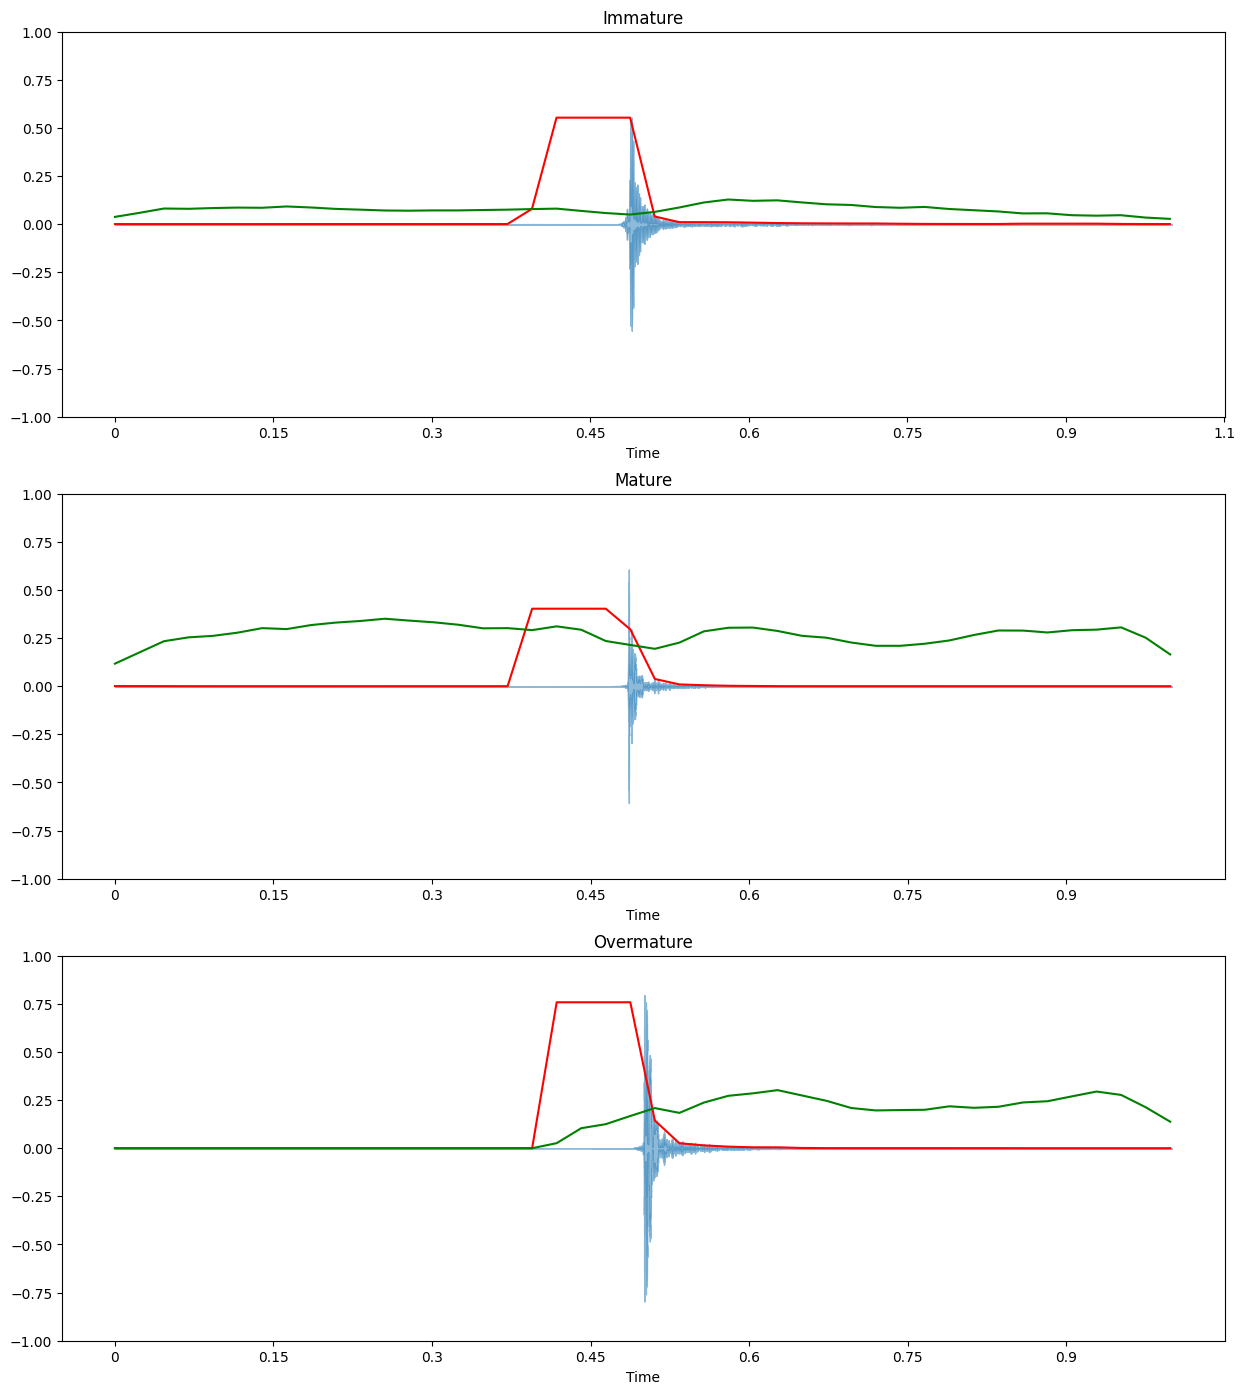

In [159]:
plt.figure(figsize=(15, 17))

ax = plt.subplot(3, 1, 1)
librosa.display.waveshow(immature, alpha=0.5)
plt.plot(t, ae_immature, color="r")
plt.plot(t, zcr_immature, color='g')
plt.ylim((-1, 1))
plt.title("Immature")

plt.subplot(3, 1, 2)
librosa.display.waveshow(mature, alpha=0.5)
plt.plot(t, ae_mature, color="r")
plt.plot(t, zcr_mature, color='g')
plt.ylim((-1, 1))
plt.title("Mature")

plt.subplot(3, 1, 3)
librosa.display.waveshow(overmature, alpha=0.5)
plt.plot(t, ae_overmature, color="r")
plt.plot(t, zcr_overmature, color='g')
plt.ylim((-1, 1))
plt.title("Overmature")

In [ ]:
from spafe.features.pncc import pncc
pnccs = []
vector_size = []

for filename in df['full_path'].values:
    wavSig, sampRate = librosa.load(filename)
    result = pncc(wavSig, fs=sampRate)
    pnccs.append(result)
    vector_size.append(result.shape)

In [77]:
def createWaveplot(data, sampleRate, maturity):
    plt.figure(figsize=(8,2))
    plt.title(f'Waveplot for {maturity} maturity', size = 15, pad = 20)
    librosa.display.waveshow(data, sr=sampleRate, alpha=0.5)
    plt.show()

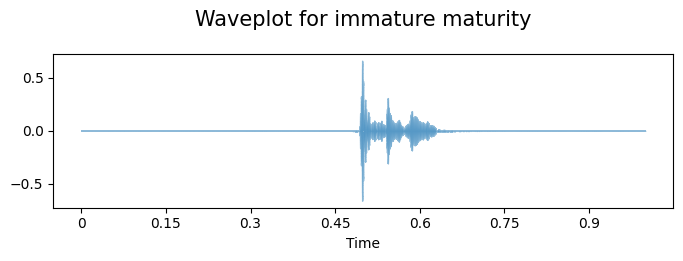

In [79]:
audio_immature, sr_immature = librosa.load('./Sample-kelapa/cut sample/Sample-kelapa-muda/wav/muda4_c.wav')
createWaveplot(audio_immature, sr_immature, "immature")
ipd.Audio('./Sample-kelapa/cut sample/Sample-kelapa-muda/wav/muda4_c.wav')

In [147]:
zero_crossing_rate = librosa.feature.zero_crossing_rate(immature)
rms_energy = librosa.feature.rms(y=immature)

In [148]:
print(zero_crossing_rate)
print(rms_energy)

[[0.03808594 0.05908203 0.08154297 0.08007812 0.08398438 0.08642578
  0.08544922 0.09228516 0.08691406 0.07958984 0.07568359 0.07128906
  0.0703125  0.07177734 0.07177734 0.07373047 0.07568359 0.07861328
  0.08105469 0.06933594 0.05810547 0.05029297 0.06396484 0.08691406
  0.11279297 0.12841797 0.12158203 0.12402344 0.11328125 0.10351562
  0.10009766 0.08935547 0.08544922 0.08984375 0.07910156 0.07275391
  0.06640625 0.05615234 0.05664062 0.046875   0.04443359 0.046875
  0.03466797 0.02783203]]
[[0.00019811 0.00023344 0.0002586  0.00026525 0.00026037 0.00024485
  0.00024057 0.00022622 0.00021647 0.00025169 0.00027446 0.00029505
  0.00029371 0.00026602 0.00027529 0.00027379 0.00030787 0.00033618
  0.00031977 0.02247876 0.08156177 0.08188904 0.08192171 0.07880455
  0.00817425 0.0039502  0.00343325 0.0028738  0.00230342 0.00189922
  0.00158517 0.00145656 0.0012035  0.00095777 0.00072078 0.00053327
  0.00051149 0.00048408 0.00047883 0.00067252 0.00067354 0.00064938
  0.00060952 0.00030821]

In [ ]:
mfccs = []
mfcc_vectors = []

for filename in df['full_path'].values:
    wavSig, sampRate = librosa.load(filename)
    result = librosa.feature.mfcc(wavSig, fs=sampRate)
    mfccs.append(result)
    mfcc_vectors.append(result.shape)